In [ ]:
# ! unzip -q "aug_seg_rgb.zip"
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/aug_seg_rgb_resize.zip"
! cp "/content/drive/MyDrive/Colab Notebooks/helper_functions.py" "helper_functions.py"

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import LSTM, Dense, GRU,Dropout, concatenate, Conv2D, MaxPooling2D, TimeDistributed, GlobalAveragePooling2D
from helper_functions import make_confusion_matrix, getPrescisionRecallF1


SEED = 42
BATCH_SIZE = 14
FRAME_WIDTH = 640
FRAME_HIGHT = 480
epochs = 50
length = 20
IMG_SIZE = 128
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
root_dir = "aug_seg_rgb_resize"
aug_seg_rgb_dir = "aug_seg_rgb"
split_dir_dict_path="/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/split_dir_dict.npy"

In [ ]:
# image_files_path = glob(f"{aug_seg_rgb_dir}/*/*/*")
# for image_path in tqdm(image_files_path):
#     new_path = image_path.replace(aug_seg_rgb_dir, root_dir)
#     if os.path.exists(new_path):
#         continue
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     image = Image.open(image_path)
#     image = image.resize((IMG_SIZE, IMG_SIZE))
#     image.save(image_path)

In [ ]:
# import os
# from glob import glob
# from PIL import Image
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor

# # Define a function to process a single image
# def process_image(image_path, aug_seg_rgb_dir, root_dir, IMG_SIZE):
#     new_path = image_path.replace(aug_seg_rgb_dir, root_dir)
#     if os.path.exists(new_path):
#         return
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     image = Image.open(image_path)
#     image = image.resize((IMG_SIZE, IMG_SIZE))
#     image.save(new_path)

# # Multi-threaded image processing
# def resize_images_multithreaded(aug_seg_rgb_dir, root_dir, IMG_SIZE, max_workers=8):
#     image_files_path = glob(f"{aug_seg_rgb_dir}/*/*/*")

#     # Use ThreadPoolExecutor for multithreading
#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         list(tqdm(executor.map(process_image, image_files_path, [aug_seg_rgb_dir]*len(image_files_path),
#                                [root_dir]*len(image_files_path), [IMG_SIZE]*len(image_files_path)),
#                   total=len(image_files_path)))

# # Example usage:
# resize_images_multithreaded(aug_seg_rgb_dir, root_dir, IMG_SIZE)


In [ ]:
class_names = sorted([x.split(f"{root_dir}/")[-1] for x in glob(f"{root_dir}/*")])
class_dict = {x:i for i,x in enumerate(class_names)}
num_classes = len(class_names)
num_classes, class_names, class_dict

(7,
 ['Clapping',
  'Meet and Split',
  'Sitting',
  'Standing Still',
  'Walking',
  'Walking While Reading Book',
  'Walking While Using Phone'],
 {'Clapping': 0,
  'Meet and Split': 1,
  'Sitting': 2,
  'Standing Still': 3,
  'Walking': 4,
  'Walking While Reading Book': 5,
  'Walking While Using Phone': 6})

In [ ]:
from collections import defaultdict


def get_train_test_split(root_dir, class_names,split_dir_dict_path):

    if os.path.exists(split_dir_dict_path):

        return np.load(split_dir_dict_path, allow_pickle=True).item()

    split_dir_dict = {

        "train": [],

        "test": [],

    }

    for class_name in class_names:

        img_dirs = glob(f"{root_dir}/{class_name}/*")
        img_dirs_dict = defaultdict(list)
        for img_dir in img_dirs:
            key = img_dir.split("/")[-1].split("_")[0]
            img_dirs_dict[key].append(img_dir)

        # print(img_dirs_dict)
        np.random.seed(42)
        keys = list(img_dirs_dict.keys())
        # print(keys)
        np.random.shuffle(keys)

        train_keys, test_keys = train_test_split(keys, test_size=0.2)

        for train_key in train_keys:
            split_dir_dict["train"].extend(img_dirs_dict[train_key])
        for test_key in test_keys:
            split_dir_dict["test"].extend(img_dirs_dict[test_key])

    np.random.seed(42)

    np.random.shuffle(split_dir_dict["train"])

    np.random.shuffle(split_dir_dict["test"])

    np.save(split_dir_dict_path, split_dir_dict)

    return np.load(split_dir_dict_path, allow_pickle=True).item()


In [ ]:
split_dir_dict = get_train_test_split(root_dir, class_names, split_dir_dict_path)

In [ ]:
train_dirs = split_dir_dict["train"]
test_dirs = split_dir_dict["test"]
len(train_dirs), len(test_dirs)

(12404, 3178)

In [ ]:
test_dirs = [x for x in test_dirs if len(x.split("/")[-1].split("_")) ==1]
len(test_dirs)

227

In [ ]:
def get_labels(image_dirs):
    labels = []
    for x in image_dirs:
        labels.append(class_dict[x.split("/")[-2]])
    return np.array(labels)

In [ ]:
def get_img_path(image_dirs):
    img_all_paths = []
    for x in image_dirs:
        img_paths = glob(f"{x}/*")
        img_paths = np.array(sorted(img_paths))
        index = np.round(np.linspace(0,len(img_paths)-1,length))
        index = index.astype(np.int8)
        img_paths = img_paths[index]
        img_all_paths.append(img_paths)
    return np.array(img_all_paths)

In [ ]:
X_train_paths = get_img_path(train_dirs)
y_train_label = get_labels(train_dirs)
X_train_paths.shape, y_train_label.shape

((12404, 20), (12404,))

In [ ]:
X_test_paths = get_img_path(test_dirs)
y_test_label = get_labels(test_dirs)
X_test_paths.shape, y_test_label.shape

((227, 20), (227,))

In [ ]:
y_train = tf.one_hot(y_train_label, depth=num_classes)
y_test = tf.one_hot(y_test_label, depth=num_classes)
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)
y_train.shape, y_test.shape

(TensorShape([12404, 7]), TensorShape([227, 7]))

In [ ]:
def process_path(image_paths, label):
    def _process_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32)
        image = tf.divide(image, 255.0)
        return image

    images = tf.map_fn(_process_image, image_paths, dtype=tf.float32)

    return images, label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test))

In [ ]:
train_ds = train_ds.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
for image_batch,label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(14, 20, 128, 128, 3)
(14, 7)


In [ ]:
for image_batch,label_batch in test_ds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(14, 20, 128, 128, 3)
(14, 7)


In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32,3,1), input_shape=(length, IMG_SIZE, IMG_SIZE, 3)))
model.add(TimeDistributed(MaxPooling2D(2)))
model.add(TimeDistributed(Conv2D(16,3,1)))
model.add(TimeDistributed(MaxPooling2D(2)))
model.add(TimeDistributed(Conv2D(32,3,1)))
model.add(TimeDistributed(MaxPooling2D(2)))
model.add(TimeDistributed(Conv2D(64,3,1)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(64))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 126, 126, 32)    │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 63, 63, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 61, 61, 16)      │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 30, 30, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 28, 28, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 14, 14, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 12, 12, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,135 (242.71 KB)

 Trainable params: 62,135 (242.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

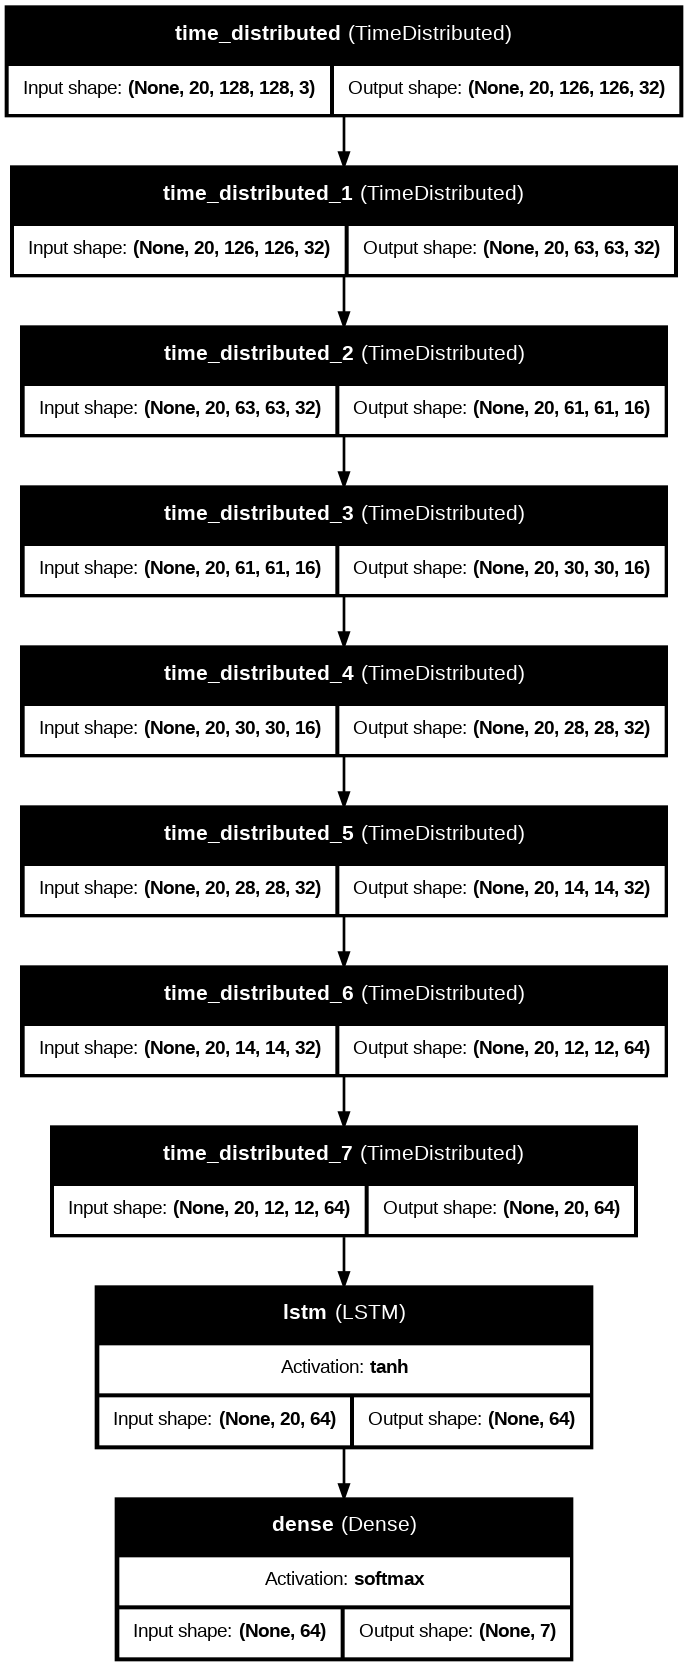

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)


In [ ]:
gdrive_Path = "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition"
checkPointName = "rgb_cnn_CheckPoint"

# Best model
best_checkpoint_path = f"{gdrive_Path}/{checkPointName}/model_best/best_model.keras"
best_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    best_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True
)

# Every epoch model
checkpoint_path = f"{gdrive_Path}/{checkPointName}/model/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path+'model_{epoch:02d}.keras',
    save_freq='epoch'
)

# Reduce learning rate
reduce_callback =  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

# History
history_path = f"{gdrive_Path}/{checkPointName}/history.txt"
save_history_callback = tf.keras.callbacks.CSVLogger(history_path, append=True)
os.makedirs(os.path.dirname(history_path), exist_ok=True)

In [ ]:
save_model_paths = glob(f'{checkpoint_path}/*.keras')
save_model_paths = sorted(save_model_paths)

save_model_paths

['/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_01.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_02.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_03.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_04.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_05.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_06.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_07.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_08.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_09.keras',
 '/content

In [ ]:
initial_epoch = 0

if len(save_model_paths) == 0:
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(save_model_paths[-1])
    initial_epoch = int(save_model_paths[-1].split('_')[-1].split('.')[0])

initial_epoch

15

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    initial_epoch=initial_epoch,
    epochs=epochs,
    callbacks=[
        best_checkpoint_callback,
        checkpoint_callback,
        reduce_callback,
        save_history_callback
    ]
)

Epoch 1/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 302s 320ms/step - accuracy: 0.3696 - loss: 1.5565 - val_accuracy: 0.6557 - val_loss: 0.8783 - learning_rate: 0.0010
Epoch 2/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 309s 308ms/step - accuracy: 0.6635 - loss: 0.8490 - val_accuracy: 0.6961 - val_loss: 0.7209 - learning_rate: 0.0010
Epoch 3/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 322s 308ms/step - accuracy: 0.7531 - loss: 0.6292 - val_accuracy: 0.6095 - val_loss: 0.9523 - learning_rate: 0.0010
Epoch 4/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 322s 308ms/step - accuracy: 0.7861 - loss: 0.5407 - val_accuracy: 0.7871 - val_loss: 0.5737 - learning_rate: 0.0010
Epoch 5/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 322s 308ms/step - accuracy: 0.8447 - loss: 0.4293 - val_accuracy: 0.8519 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 6/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 274s 308ms/step - accuracy: 0.8663 - loss: 0.3660 - val_accuracy: 0.8650 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 7/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 322s 308ms/step - accura

In [ ]:
def plot_loss_curves_history_path(history_path):
    """
    csv history
    """
    history = pd.read_csv(history_path)
    loss = history['loss']
    val_loss = history['val_loss']

    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    epochs = range(len(history['epoch']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    #  save
    plt.savefig(f"loss.png")

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    plt.savefig(f"accuracy.png")

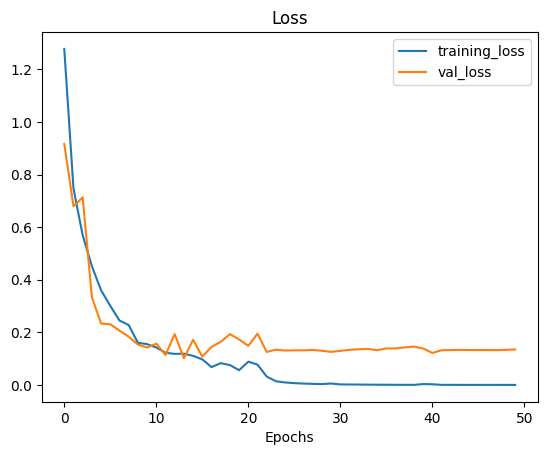

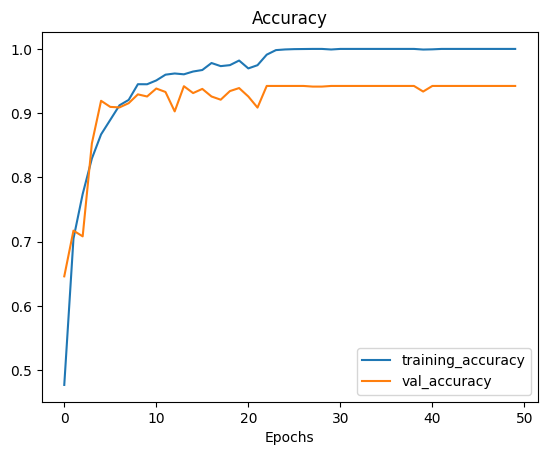

In [ ]:
plot_loss_curves_history_path(history_path)

In [ ]:
temp_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/rgb_cnn_CheckPoint/model/model_10.keras")
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(temp_model.predict(x, verbose=0), axis=-1)], axis=0)

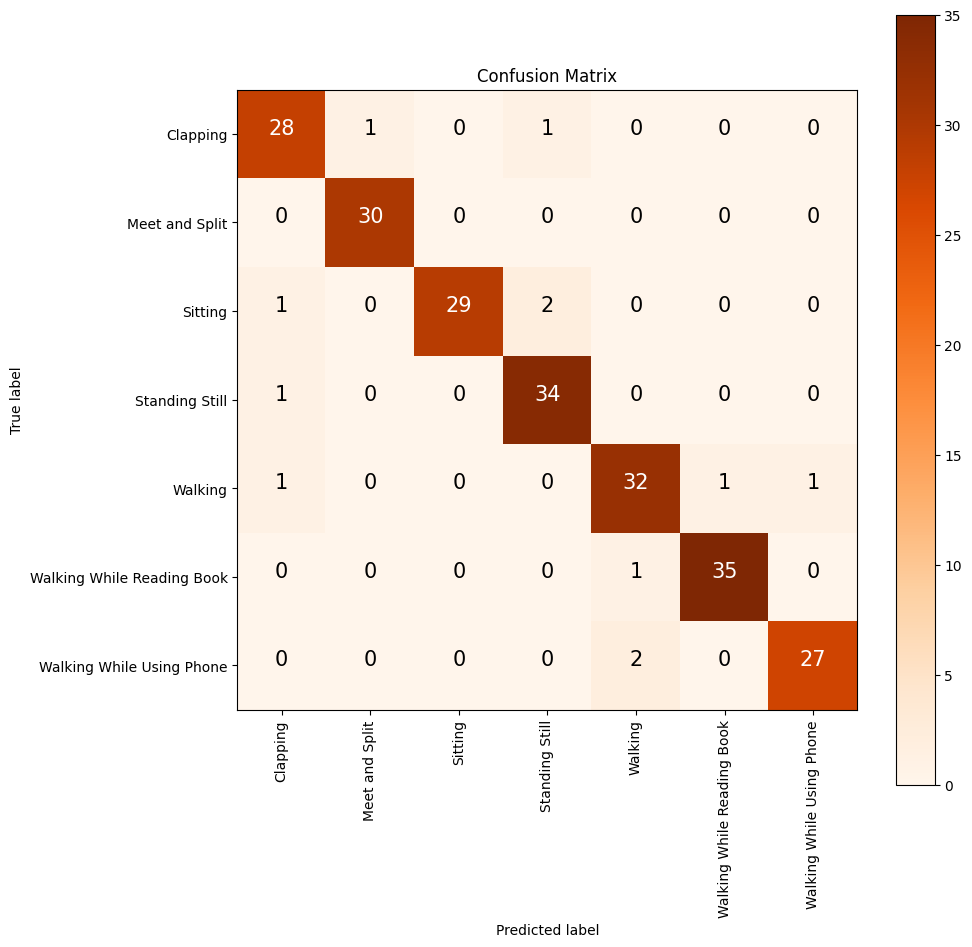

In [ ]:
make_confusion_matrix(y_true, y_pred, list(class_names))

In [ ]:
results = getPrescisionRecallF1(y_true, y_pred, class_names)
print(results)
# with open(f"{gdrive_Path}/{checkPointName}/PrescisionRecallF1.txt", 'w') as file:
#     file.write(results)

        Task           precision      recall        f1       Accuracy 
______________________________________________________________________
      Clapping           0.9667       0.9667       0.9667       0.9667  
   Meet and Split        0.9677       1.0000       0.9836       1.0000  
      Sitting            1.0000       1.0000       1.0000       1.0000  
   Standing Still        1.0000       0.9714       0.9855       0.9714  
      Walking            0.9697       0.9143       0.9412       0.9143  
Walking While Reading Book     0.9730       1.0000       0.9863       1.0000  
Walking While Using Phone     0.9333       0.9655       0.9492       0.9655  
______________________________________________________________________
      Average            0.9729       0.9740       0.9732       0.9736  
